## Importing the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import torch
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import time

## STEP 1:

### Dataset used: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

In [2]:
df = pd.read_csv("/kaggle/input/tweets-csv/Tweets.csv")

print("\nMain Statistics")
print("\nDataset Information:\n")
print(df.info())

print("\nDataset description:\n")
print(df.describe())



Main Statistics

Dataset Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created       

### First 5 rows from the dataset

In [3]:
df.head(5)

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Dataset Description: 
#### This dataset has tweets about U.S. airlines and their sentiment classification as data. There are 3 sentiment categories ( positive, negative, and neutral) present in this dataset and each tweet is labeled with one of three sentiments. 

### Checking for missing Values in each column

In [4]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

### Dropped the columns with more missing values and replaced the categorical fields like negativereason, tweet_location, and user_timezone with "Not Specified" for null values, and negativereason_confidence is set to 0 for all null values.

In [5]:
df = df.copy()  

df.drop(columns=['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord'], inplace=True)

df.loc[:, 'negativereason'] = df['negativereason'].fillna("Not Specified")
df.loc[:, 'negativereason_confidence'] = df['negativereason_confidence'].fillna(0)
df.loc[:, 'tweet_location'] = df['tweet_location'].fillna("Not Specified")
df.loc[:, 'user_timezone'] = df['user_timezone'].fillna("Not Specified")


In [6]:
df.isnull().sum()

tweet_id                        0
airline_sentiment               0
airline_sentiment_confidence    0
negativereason                  0
negativereason_confidence       0
airline                         0
name                            0
retweet_count                   0
text                            0
tweet_created                   0
tweet_location                  0
user_timezone                   0
dtype: int64

## Descriptive Statistics:

In [7]:
n_sample = df.shape[0]
print(f"Number of samples present: {n_sample}")

c_distribution = df['airline_sentiment'].value_counts(normalize=True) * 100
print("\nClass Distribution in Dataset(in %):\n", c_distribution)

df['review_length_words'] = df['text'].apply(lambda x: len(x.split()))
df['review_length_chars'] = df['text'].apply(len)

avg_word = df['review_length_words'].mean()
avg_char = df['review_length_chars'].mean()

print(f"\nAverage review length of words : {avg_word:.2f} ")
print(f"Average review length in characters: {avg_char:.2f} ")

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['text'])
vocab_size = len(vectorizer.get_feature_names_out())

print(f"\nnumber of unique words : {vocab_size} ")


Number of samples present: 14640

Class Distribution in Dataset(in %):
 airline_sentiment
negative    62.691257
neutral     21.168033
positive    16.140710
Name: proportion, dtype: float64

Average review length of words : 17.65 
Average review length in characters: 103.82 

number of unique words : 15051 


## Visualizations:

### Bar chart of sentiment distirbution of each tweets

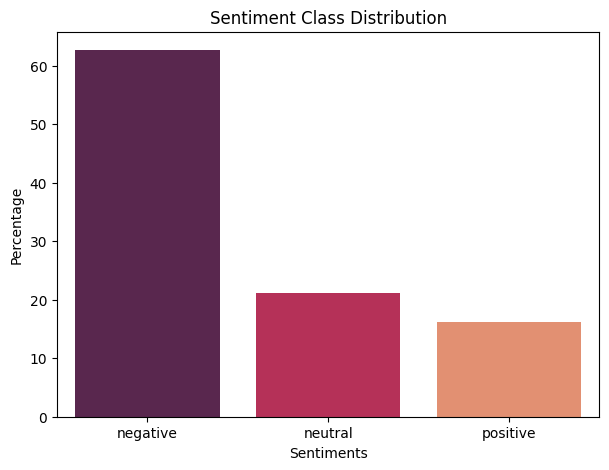

In [8]:
plt.figure(figsize=(7, 5))
sns.barplot(x=c_distribution.index, y=c_distribution.values, palette="rocket")
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiments")
plt.ylabel("Percentage")
plt.show()

### Histogram plots of review length in both words and characters frequencies

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


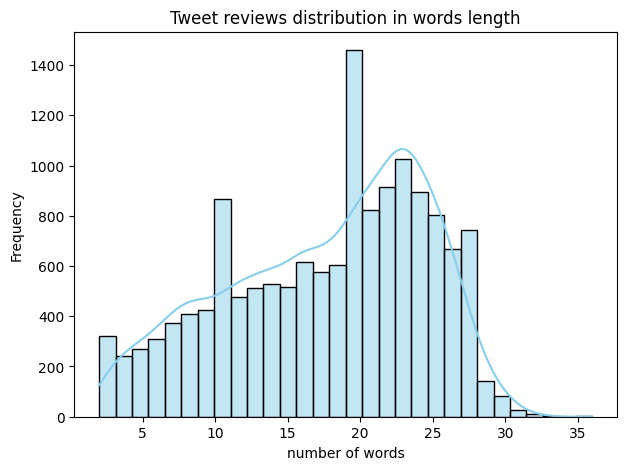

In [9]:
plt.figure(figsize=(7, 5))
sns.histplot(df['review_length_words'], bins=30, kde=True, color='skyblue')
plt.title("Tweet reviews distribution in words length")
plt.xlabel("number of words")
plt.ylabel("Frequency")
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


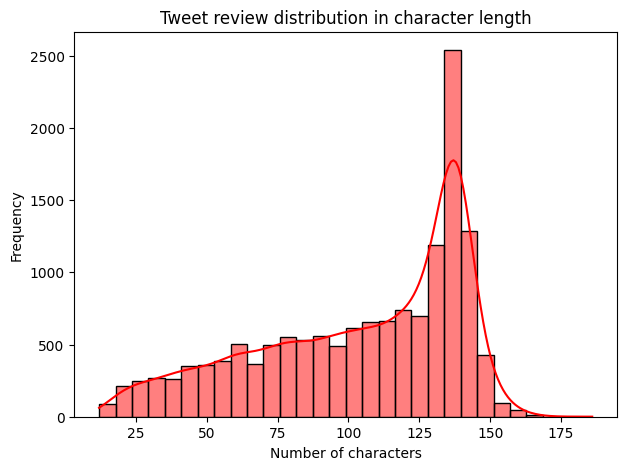

In [11]:
plt.figure(figsize=(7, 5))
sns.histplot(df['review_length_chars'], bins=30, kde=True, color='red')
plt.title("Tweet review distribution in character length")
plt.xlabel("Number of characters")
plt.ylabel("Frequency")
plt.show()


## Word Clouds of each sentiments class

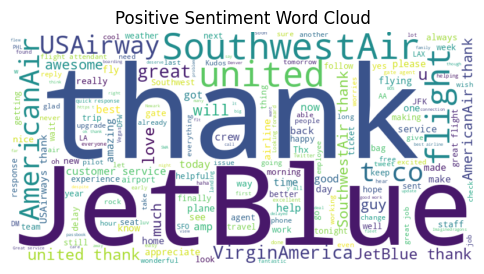

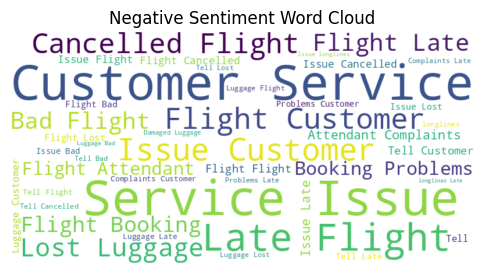

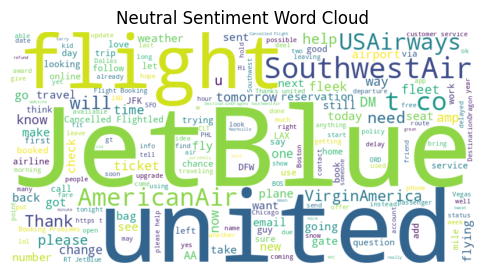

In [12]:
positive_reviews = df[df['airline_sentiment'] == 'positive']['text']
negative_reviews = df[df['airline_sentiment'] == 'negative']['negativereason']
neutral_reviews = df[df['airline_sentiment'] == 'neutral']['text']

def generate_wordcloud(text_data, title):
    if text_data.shape[0] > 0:  
        wordcloud = WordCloud(width=800, height=400, background_color='white',colormap='viridis').generate(' '.join(text_data))
        plt.figure(figsize=(6, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(title)
        plt.axis('off')
        plt.show()
    else:
        print(f"Words not available for {title} !!")

generate_wordcloud(positive_reviews, 'Positive Sentiment Word Cloud')
generate_wordcloud(negative_reviews, 'Negative Sentiment Word Cloud')
generate_wordcloud(neutral_reviews, 'Neutral Sentiment Word Cloud')


## Data Preparation - Tokenizing the text data using nltk toolkit

In [13]:
nltk.download('punkt_tab')

start_time = time.time()
nltk_tokens = [word_tokenize(sentence) for sentence in df['text']]
nltk_time = time.time() - start_time
print(f"Time taken for NLTK tokenization: {nltk_time:.4f} seconds")


[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
Time taken for NLTK tokenization: 2.7743 seconds


In [14]:
n_tokens = [word for sentence in nltk_tokens for word in sentence]
vocab = Counter(n_tokens)

unique_words = list(vocab.keys())

print(f"Vocabulary size: {len(vocab)}")
print(f"10 common words from the vocabulary: {vocab.most_common(10)}")

Vocabulary size: 20118
10 common words from the vocabulary: [('@', 16583), ('.', 13610), ('to', 8589), ('I', 6347), ('the', 5796), ('!', 5312), ('?', 4678), ('a', 4364), (',', 4156), ('for', 3953)]


### The below cell creates a vocabulary by mapping unique words from the dataset to integer indices. It converts the tokenized text into numeric sequence with this vocabulary. 
### Sequences are padded with uniform length of 40 to handle different review lengths. Padding ensures consistency, while truncation prevents excessive sequence lengths. The resulting padded_seq_tensor contains the padded sequences of tweets.

In [15]:

word_index = {word: idx + 1 for idx, word in enumerate(unique_words)}  
word_index['UNK'] = 0 

indexed_lines = []

for line in nltk_tokens:
    indexed_line = [word_index.get(word, word_index['UNK']) for word in line]
    indexed_lines.append(indexed_line) 

max_length = 40
padded_seq = []

for line in indexed_lines:
    if len(line) < max_length:
        padding_len = max_length - len(line)
        padded_line = line + [0] * padding_len 
    else:
        padded_line = line[:max_length] 

    padded_seq.append(padded_line)

padded_seq_tensor = torch.tensor(padded_seq)
print(f"Padded sequences tensor:\n{padded_seq_tensor}")


Padded sequences tensor:
tensor([[   1,    2,    3,  ...,    0,    0,    0],
        [   1,    2,    7,  ...,    0,    0,    0],
        [   1,    2,   17,  ...,    0,    0,    0],
        ...,
        [   1, 1704, 1203,  ...,    0,    0,    0],
        [   1, 1704,    8,  ...,    0,    0,    0],
        [   1, 1704,  286,  ...,    0,    0,    0]])


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Splitting the dataset into train,test and validation

In [17]:
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['airline_sentiment'])  
y_encoded_tensor = torch.tensor(y_encoded, dtype=torch.long)

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

X_train, X_tmp, y_train, y_tmp = train_test_split(
    padded_seq_tensor, y_encoded_tensor, test_size=0.3, random_state=42, stratify=y_encoded_tensor
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp
)

X_train, X_val, X_test = map(torch.tensor, (X_train, X_val, X_test))

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training dataset size: {len(X_train)}")
print(f"Validation dataset size: {len(X_val)}")
print(f"Test dataset size: {len(X_test)}")


Training dataset size: 10248
Validation dataset size: 2196
Test dataset size: 2196


<ipython-input-17-63ab5cf714dc>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, X_val, X_test = map(torch.tensor, (X_train, X_val, X_test))


## Baseline Model:
#### The BaseLSTM_sentiment model has an embedding layer to convert words into numerical, with a dimension as 100. The model includes 3 bidirectional LSTM layers, dropout layers with drouput as 0.3 after each LSTM to prevent from overfitting,and a fully connected layer maps the LSTM output to 3 sentiment classes (positive, negative, neutral). The activation function used is softmax for getting probability distributions for sentiment classification accurately.

In [19]:
import torch.nn as nn
from torchinfo import summary
import torch.nn.functional as F

class BaseLSTM_sentiment(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, num_classes, dropout_prob):
        super(BaseLSTM_sentiment, self).__init__()

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

        self.lstm1 = nn.LSTM(embedding_dim, hidden_units, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(dropout_prob)

        self.lstm2 = nn.LSTM(hidden_units * 2, hidden_units, batch_first=True, bidirectional=True)
        self.dropout2 = nn.Dropout(dropout_prob)

        self.lstm3 = nn.LSTM(hidden_units * 2, hidden_units, batch_first=True, bidirectional=True)
        self.dropout3 = nn.Dropout(dropout_prob)

        self.fc = nn.Linear(hidden_units * 2, num_classes)

    def forward(self, x):
        x = torch.clamp(x, min=0, max=self.embedding.num_embeddings - 1)
        
        x = self.embedding(x)
        
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x, _ = self.lstm3(x)
        x = self.dropout3(x)
        x = x[:, -1, :]        
        x = self.fc(x)  
        x = F.softmax(x, dim=1)
        return x

vocab_size = 20118  
embedding_dim = 100  
hidden_units = 128  
num_classes = 3  
dropout_prob = 0.3
batch_size = 32
seq_length = 40 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_1 = BaseLSTM_sentiment(vocab_size, embedding_dim, hidden_units, num_classes, dropout_prob).to(device)

summary(model_1, input_size=(batch_size, seq_length), dtypes=[torch.long])


Layer (type:depth-idx)                   Output Shape              Param #
BaseLSTM_sentiment                       [32, 3]                   --
├─Embedding: 1-1                         [32, 40, 100]             2,011,800
├─LSTM: 1-2                              [32, 40, 256]             235,520
├─Dropout: 1-3                           [32, 40, 256]             --
├─LSTM: 1-4                              [32, 40, 256]             395,264
├─Dropout: 1-5                           [32, 40, 256]             --
├─LSTM: 1-6                              [32, 40, 256]             395,264
├─Dropout: 1-7                           [32, 40, 256]             --
├─Linear: 1-8                            [32, 3]                   771
Total params: 3,038,619
Trainable params: 3,038,619
Non-trainable params: 0
Total mult-adds (G): 1.38
Input size (MB): 0.01
Forward/backward pass size (MB): 8.89
Params size (MB): 12.15
Estimated Total Size (MB): 21.05

### Trained model with optimizer as Adam  with ReduceLROnPlateau scheduler

In [29]:
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

def test_model(model, test_loader, criterion, device):
    
    model.eval()
    n_test_preds = []
    n_test_labels = []
    correct = 0
    test_loss = 0

    with torch.no_grad():
        for inp, labels in test_loader:
            inp, labels = inp.to(device), labels.to(device).long()
            opt = model(inp)
            loss = criterion(opt, labels)
            test_loss += loss.item()
            preds = torch.argmax(opt, dim=1)
            correct += (preds == labels).sum().item()

            n_test_preds.extend(preds.cpu().numpy())
            n_test_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader)
    test_acc = correct / len(test_loader.dataset)
    precision, recall, f1, _ = precision_recall_fscore_support(
        n_test_labels, n_test_preds, average='weighted', zero_division=0)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}, Test Precision: {precision:.4f}")

    return test_loss, test_acc, precision, recall, f1, n_test_labels, n_test_preds


def eval_model(model, train_loader, val_loader, criterion, device, epochs=10):
    
    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.00001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, correct = 0, 0
        n_train_preds, n_train_labels = [], []

        for inp, labels in train_loader:
            inp, labels = inp.to(device), labels.to(device).long()
            optimizer.zero_grad()
            opt = model(inp)
            loss = criterion(opt, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = torch.argmax(opt, dim=1)
            correct += (preds == labels).sum().item()

            n_train_preds.extend(preds.cpu().numpy())
            n_train_labels.extend(labels.cpu().numpy())

        train_loss /= len(train_loader)
        train_acc = correct / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        val_loss, correct = 0, 0
        n_val_preds, n_val_labels = [], []

        with torch.no_grad():
            for inp, labels in val_loader:
                inp, labels = inp.to(device), labels.to(device).long()
                opt = model(inp)
                loss = criterion(opt, labels)
                val_loss += loss.item()
                preds = torch.argmax(opt, dim=1)
                correct += (preds == labels).sum().item()

                n_val_preds.extend(preds.cpu().numpy())
                n_val_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = correct / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_acc*100:.2f}, "
              f"Val Loss = {val_loss:.4f}, Val Accuracy = {val_acc*100:.2f}")

        scheduler.step(val_loss)

    return model, train_losses, val_losses, train_accs, val_accs


def plot_TrainVal_curves(train_losses, val_losses, train_accs, val_accs):
    
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", color='b')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", color='r')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accs) + 1), train_accs, label="Train Accuracy", color='b')
    plt.plot(range(1, len(val_accs) + 1), val_accs, label="Validation Accuracy", color='r')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and validation accuracy')

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(true_labels, predicted_labels, class_names=None):
    
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


In [26]:
print("\nTraining the LSTM Base model:\n")

class_counts = torch.tensor([62.69, 21.17, 16.14])  
total_samples = class_counts.sum()
class_weights = total_samples / (class_counts * len(class_counts))
class_weights = class_weights / class_weights.min() 
tensor_class_weight = class_weights.clone().detach().to(device)


criterion = nn.CrossEntropyLoss(weight=tensor_class_weight)

trained_model, train_losses, val_losses, train_accs, val_accs = eval_model(
    model_1, train_loader, val_loader, criterion, device, epochs=10)

print("\nEvaluation results:\n")
test_loss, test_acc, precision, recall, f1, true_labels, preds = test_model(
    trained_model, test_loader, criterion, device)



Training the LSTM Base model:

Epoch 1: Train Loss = 0.9468, Train Accuracy = 66.67, Val Loss = 0.9602, Val Accuracy = 65.89
Epoch 2: Train Loss = 0.9355, Train Accuracy = 67.32, Val Loss = 0.9618, Val Accuracy = 69.44
Epoch 3: Train Loss = 0.8955, Train Accuracy = 71.11, Val Loss = 0.8952, Val Accuracy = 70.58
Epoch 4: Train Loss = 0.8474, Train Accuracy = 72.54, Val Loss = 0.8727, Val Accuracy = 66.58
Epoch 5: Train Loss = 0.8181, Train Accuracy = 74.93, Val Loss = 0.8841, Val Accuracy = 70.26
Epoch 6: Train Loss = 0.8287, Train Accuracy = 74.02, Val Loss = 0.8878, Val Accuracy = 71.90
Epoch 7: Train Loss = 0.8136, Train Accuracy = 76.00, Val Loss = 0.8622, Val Accuracy = 70.67
Epoch 8: Train Loss = 0.7897, Train Accuracy = 77.48, Val Loss = 0.8478, Val Accuracy = 71.72
Epoch 9: Train Loss = 0.7652, Train Accuracy = 80.15, Val Loss = 0.8466, Val Accuracy = 73.13
Epoch 10: Train Loss = 0.7529, Train Accuracy = 81.71, Val Loss = 0.8537, Val Accuracy = 74.77

Evaluation results:

Test 

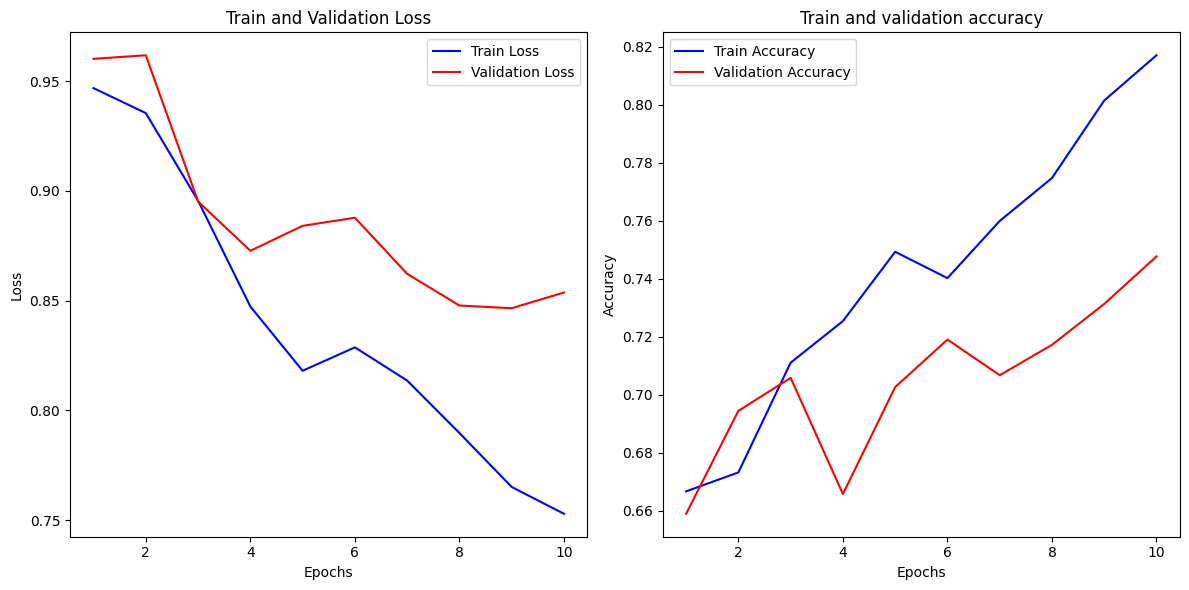

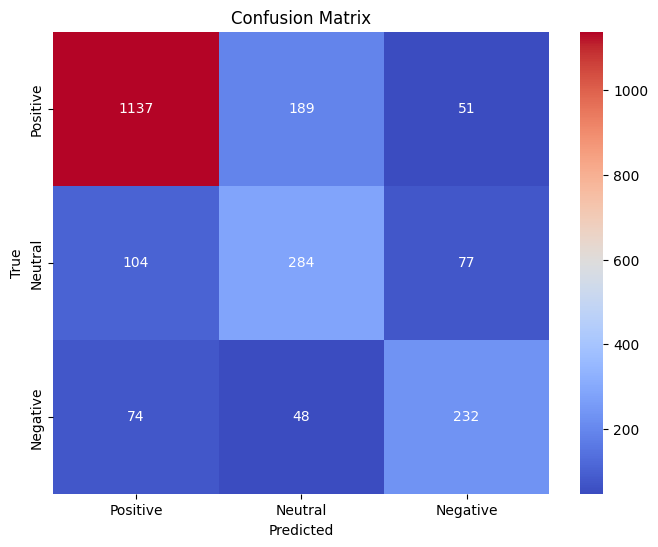

In [27]:
plot_TrainVal_curves(train_losses, val_losses, train_accs, val_accs)

plot_confusion_matrix(true_labels, preds, class_names=['Positive', 'Neutral', 'Negative'])

### Inference:
#### As seen the training loss has consistently decreased, and accuracy achived 81.71% approx, which indicates effective learning. Also, the validation loss showed slight fluctuations, but the accuracy improved to 74.77%, indicating the model generalized well. The model achieved a test accuracy of 75.27% and a test precision of 0.7615,indicating the model performed well in unseen data as well. 
#### From the Confusion matrix it shows that the model performed well in classifying the positive sentiments with 1137 correct predictions, whereas multiple neutral and negative sentiments are getting miscalssified as positive.

In [28]:
torch.save(model_1.state_dict(), 'baseline_best_model.pt')

## STEP 3: Improving the Baseline model

#### In the improved model (GRU_Model ) used bidirectional GRU layers instead of LSTM to improve sequence processing. The model has 3 GRU layers, each with dropout of 0.3. An attention mechanism is added to capture the relevant parts of the input by computing attention weights which creates focused context representation. The attention mechanism assists the model to focus on key informations and captures the long-range dependencies. The model also includes an embedding layer to convert words into numbers, and a fully connected layer to classfiy the sentiments categories. 

In [30]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, 1)  

    def forward(self, rnn_out):
        attn_weights = torch.softmax(self.attn(rnn_out), dim=1)
        context = torch.sum(attn_weights * rnn_out, dim=1)
        return context

class GRU_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, num_classes, dropout_prob):
        super(GRU_Model, self).__init__()

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

        self.gru1 = nn.GRU(embedding_dim, hidden_units, batch_first=True, bidirectional=True)
        self.gru2 = nn.GRU(hidden_units * 2, hidden_units, batch_first=True, bidirectional=True)
        self.gru3 = nn.GRU(hidden_units * 2, hidden_units, batch_first=True, bidirectional=True)

        self.dropout = nn.Dropout(dropout_prob)
        self.attention = Attention(hidden_units)
        
        self.fc = nn.Linear(hidden_units * 2, num_classes)

    def forward(self, x):
        
        x = torch.clamp(x, min=0, max=self.embedding.num_embeddings - 1)
        x = self.embedding(x)
       
        x, _ = self.gru1(x)
        x = self.dropout(x) 
        x, _ = self.gru2(x)
        x = self.dropout(x)
        x, _ = self.gru3(x)
       
        x = self.dropout(x)
        x = self.attention(x)
        x = self.fc(x)
        return x

vocab_size = 20118  
embedding_dim = 100 
hidden_units = 128 
num_classes = 3 
dropout_prob = 0.5
batch_size = 32 
seq_length = 40 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2 = GRU_Model(vocab_size, embedding_dim, hidden_units, num_classes, dropout_prob).to(device)

summary(model, input_size=(batch_size, seq_length), dtypes=[torch.long])


Layer (type:depth-idx)                   Output Shape              Param #
BaseLSTM_sentiment                       [32, 3]                   --
├─Embedding: 1-1                         [32, 40, 100]             2,011,800
├─LSTM: 1-2                              [32, 40, 256]             235,520
├─Dropout: 1-3                           [32, 40, 256]             --
├─LSTM: 1-4                              [32, 40, 256]             395,264
├─Dropout: 1-5                           [32, 40, 256]             --
├─LSTM: 1-6                              [32, 40, 256]             395,264
├─Dropout: 1-7                           [32, 40, 256]             --
├─Linear: 1-8                            [32, 3]                   771
Total params: 3,038,619
Trainable params: 3,038,619
Non-trainable params: 0
Total mult-adds (G): 1.38
Input size (MB): 0.01
Forward/backward pass size (MB): 8.89
Params size (MB): 12.15
Estimated Total Size (MB): 21.05

#### Trained the model with SGD optimizer along with StepLR scheduler

In [31]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    n_test_preds = []
    n_test_labels = []
    correct = 0
    test_loss = 0

    with torch.no_grad():
        for inp, labels in test_loader:
            inp, labels = inp.to(device), labels.to(device).long()
            opt = model(inp)
            loss = criterion(opt, labels)
            test_loss += loss.item()
            preds = torch.argmax(opt, dim=1)
            correct += (preds == labels).sum().item()

            n_test_preds.extend(preds.cpu().numpy())
            n_test_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader)
    test_acc = correct / len(test_loader.dataset)
    precision, recall, f1, _ = precision_recall_fscore_support(
        n_test_labels, n_test_preds, average='weighted', zero_division=0)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}, Test Precision: {precision:.4f}")

    return test_loss, test_acc, precision, recall, f1, n_test_labels, n_test_preds


def eval_model(model, train_loader, val_loader, criterion, device, epochs=10):
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.00001) 
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, correct = 0, 0
        n_train_preds, n_train_labels = [], []

        for inp, labels in train_loader:
            inp, labels = inp.to(device), labels.to(device).long()
            optimizer.zero_grad()
            opt = model(inp)
            loss = criterion(opt, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = torch.argmax(opt, dim=1)
            correct += (preds == labels).sum().item()

            n_train_preds.extend(preds.cpu().numpy())
            n_train_labels.extend(labels.cpu().numpy())

        train_loss /= len(train_loader)
        train_acc = correct / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        val_loss, correct = 0, 0
        n_val_preds, n_val_labels = [], []

        with torch.no_grad():
            for inp, labels in val_loader:
                inp, labels = inp.to(device), labels.to(device).long()
                opt = model(inp)
                loss = criterion(opt, labels)
                val_loss += loss.item()
                preds = torch.argmax(opt, dim=1)
                correct += (preds == labels).sum().item()

                n_val_preds.extend(preds.cpu().numpy())
                n_val_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = correct / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_acc*100:.2f}, "
              f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc*100:.2f}")

        scheduler.step()

    return model, train_losses, val_losses, train_accs, val_accs


def plot_TrainVal_curves(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", color='b')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", color='r')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accs) + 1), train_accs, label="Train Accuracy", color='b')
    plt.plot(range(1, len(val_accs) + 1), val_accs, label="Validation Accuracy", color='r')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Train and Validation Accuracy')

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(true_labels, predicted_labels, class_names=None):
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


In [40]:

epochs = 10 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2 = GRU_Model(vocab_size, embedding_dim, hidden_units, num_classes, dropout_prob).to(device)

criterion = nn.CrossEntropyLoss()

print("\nTraining the improved model\n")
model_2, train_losses_2, val_losses_2, train_accs_2, val_accs_2 = eval_model(
    model_2, train_loader, val_loader, criterion, device, epochs)


print("\nEvaluation of improved model\n")
test_loss_2, test_acc_2, precision_2, recall_2, f1_2, all_test_labels, all_test_preds = test_model(
    model_2, test_loader, criterion, device)





Training the improved model

Epoch 1: Train Loss = 0.8316, Train Accuracy = 64.93, Val Loss = 0.7270, Val Acc = 69.67
Epoch 2: Train Loss = 0.7181, Train Accuracy = 70.57, Val Loss = 0.7144, Val Acc = 69.44
Epoch 3: Train Loss = 0.6659, Train Accuracy = 72.48, Val Loss = 0.6441, Val Acc = 73.45
Epoch 4: Train Loss = 0.6198, Train Accuracy = 74.58, Val Loss = 0.6361, Val Acc = 73.95
Epoch 5: Train Loss = 0.5819, Train Accuracy = 76.44, Val Loss = 0.6368, Val Acc = 74.50
Epoch 6: Train Loss = 0.5389, Train Accuracy = 78.60, Val Loss = 0.6035, Val Acc = 75.50
Epoch 7: Train Loss = 0.5157, Train Accuracy = 79.15, Val Loss = 0.6024, Val Acc = 76.37
Epoch 8: Train Loss = 0.4994, Train Accuracy = 79.99, Val Loss = 0.6149, Val Acc = 76.37
Epoch 9: Train Loss = 0.4781, Train Accuracy = 80.78, Val Loss = 0.6025, Val Acc = 76.91
Epoch 10: Train Loss = 0.4592, Train Accuracy = 81.34, Val Loss = 0.6117, Val Acc = 76.82

Evaluation of improved model

Test Loss: 0.5795, Test Accuracy: 77.64, Test Pr

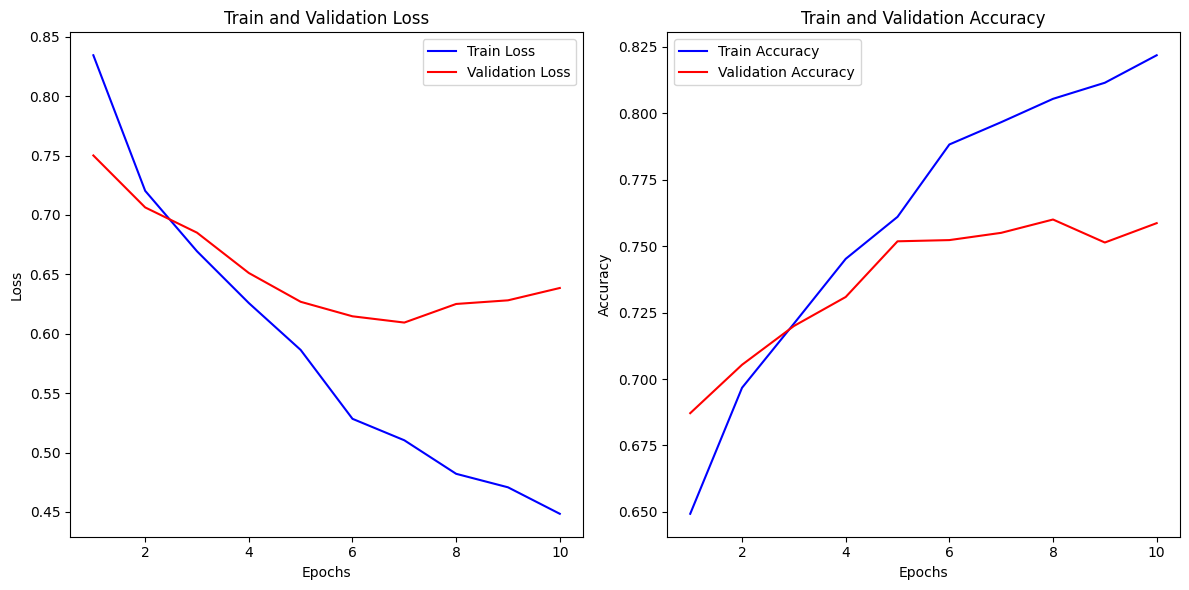

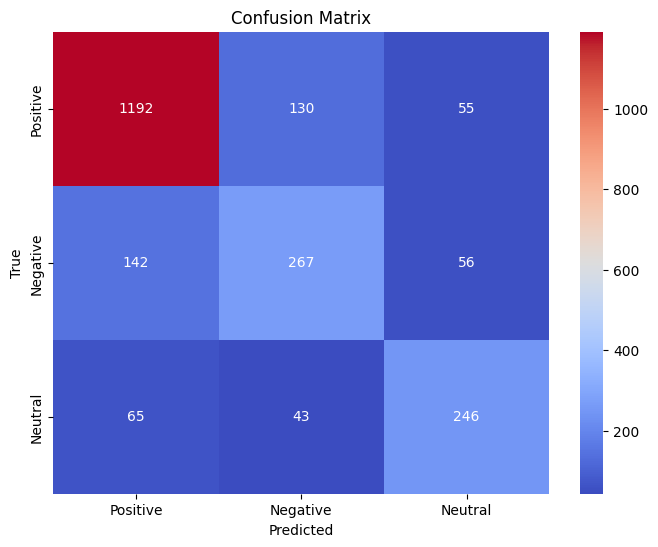

In [41]:
plot_TrainVal_curves(train_losses, val_losses, train_accs, val_accs)

plot_confusion_matrix(all_test_labels, all_test_preds, class_names=["Positive", "Negative", "Neutral"])

### Inference: 
#### From the plot,the GRU model shows strong training metrics, as the training loss consistently decreased from 0.83 to 0.45 and the training accuracy is increased from 65% to over 81.34%, showing better learning. Though validation loss is not decreasing much, the accuracy has improved from 69.67 to 76.82 shows that the model is generalising well, achieving a test accuracy of 77.64 indicating the model has improved.
#### From the Confusion matrix this model also excels at classifying the "Positive" sentiments with 1192 correct predictions, and some misclassifications of "Negative" and "Neutral" sentiments, the GRU model shows better performance in sentiment classification. 

In [44]:
torch.save(model_2.state_dict(), 'improved_best_model_77_2.pt')

In [54]:
def plot_comparison(base_train_losses, base_val_losses, base_train_accs, base_val_accs,
                    improved_train_losses, improved_val_losses, improved_train_accs, improved_val_accs,
                    epochs=10):

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), base_train_losses, label="LSTM train Loss", color='b', linestyle='--')
    plt.plot(range(1, epochs+1), base_val_losses, label="LSTM Val Loss", color='r')
    plt.plot(range(1, epochs+1), improved_train_losses, label="GRU train Loss", color='g',linestyle='--')
    plt.plot(range(1, epochs+1), improved_val_losses, label="GRU val Loss", color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), base_train_accs, label="LSTM train Accuracy", color='b', linestyle='--')
    plt.plot(range(1, epochs+1), base_val_accs, label="LSTM val Accuracy", color='r')
    plt.plot(range(1, epochs+1), improved_train_accs, label="GRU Train Accuracy", color='g', linestyle='--')
    plt.plot(range(1, epochs+1), improved_val_accs, label="GRU Val Accuracy", color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()



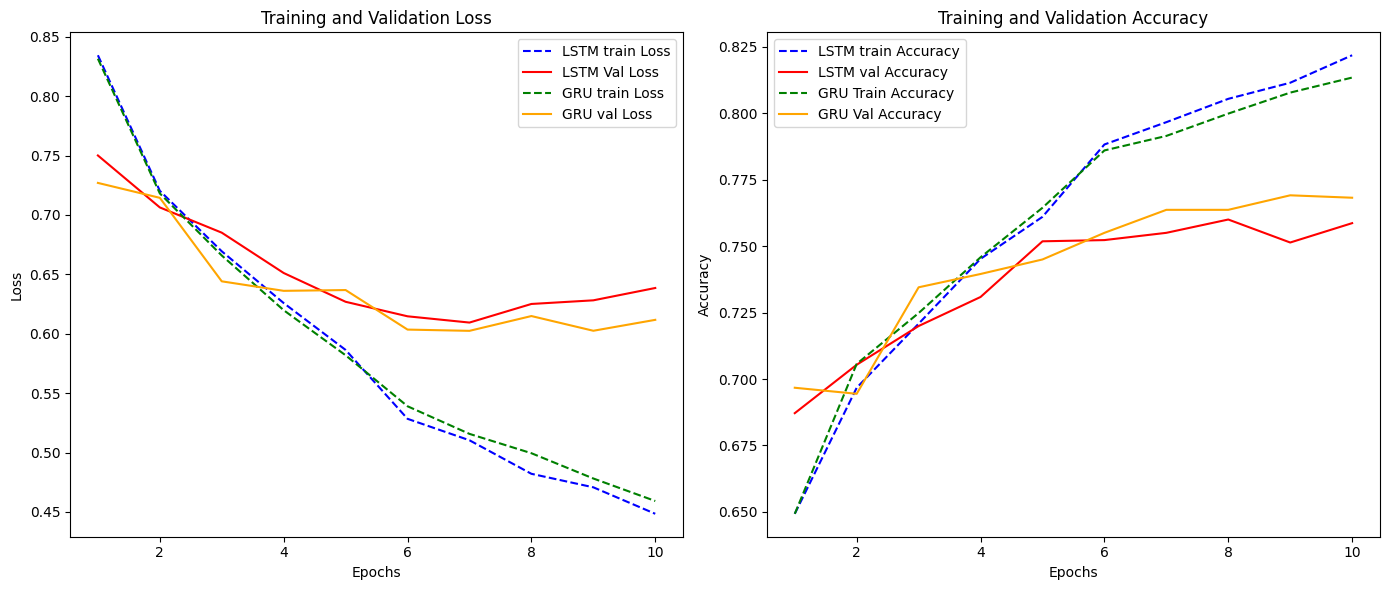

In [55]:
plot_comparison(train_losses, val_losses, train_accs, val_accs,
                train_losses_2, val_losses_2, train_accs_2, val_accs_2)

### Inference:
#### The improved model with GRU shows better performance than the base LSTM model. The training and validation loss curves shows stable decrease, with the improved model showing smooth convergence compared to the base LSTM model fluctuations. The accuracy curves also shows better performance in both training and validation accuracy for the improved model with GRU.
#### The techniques such as dropout, learning rate scheduling, and weight initialization has contributed for better generalization and reduced overfitting. The base LSTM model faced changelles with higher validation loss and lower accuracy, but in the improved model the regularization techniques and the optimizer has assisted the model to perform well.

## STEP 4:

#### 1. The dataset used has tweets about U.S. airlines and their sentiment classification as data. There are 3 sentiment categories ( positive, negative, and neutral) present in this dataset and each tweet is labeled with one of three sentiments. The dataset consists of 14,640 samples,and the vocabulary size is 20118. 
#### 2. Architectures: 
#### Base model : The baseline model uses 3 bidirectional LSTM layers with dropout for regularization, followed by a fully connected layer for sentiment classification.
#### Improved model: In this model the LSTM layers is replaced with GRU layers. And it includes an attention mechanism to focus on the most relevant features of the input sequence, which helps the model to capture more relevant features for sentiment classification. 
#### Both the base and improved models, used an embedding layer and a fully connected layer.
#### 3. From the evaluation results, the improved model with GRU shows better performance. The training and validation loss consistently decreased in loss over the epochs, which showed better convergence and stability. The improved model achieved higher validation accuracy, which shows better generalization in unseen data. The improved model includes a GRU architecture and attention mechanism, which helps the model to focus on the important sequence , improving the overall performance of the model.
#### The improved model's confusion matrix shows that the the model makes less misclasssifications than the base model.
#### 4. The LSTM models are good at handling long sequences and understanding the flow of information over time. However, this model requires a more processing power and memory, particularly when working with large datasets. These models are also sensitive to settings like learning rate, number of layers, and batch size, which requires to be adjusted for the better results. 

## References:

#### https://pytorch.org/tutorials/beginner/saving_loading_models.html
#### https://www.nltk.org/
#### https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment
#### https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
#### https://pytorch.org/docs/stable/generated/torch.nn.GRU.html